# Importing Necessary Modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

#For Logistic Regression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

# For model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Preview of cleaned dataset

In [2]:
df = pd.read_csv("20k cleaned.csv")
df.set_index("id", inplace=True)
df.head()

,title,text,label,label_translated,title_char_count,text_char_count,title_word_count,text_word_count,title_stopword_count,text_stopword_count,text_lemmatized,title_lemmatized,title_polarity,title_polarity_score,text_polarity,text_polarity_score,title_emotion,text_emotion
id,,,,,,,,,,,,,,,,,,
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment expected Barack Obama Members FYF F...,0,fake,130,5049,18,871,6,48,No comment expect Barack Obama Members FYF Fuk...,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,neutral,0.630,neutral,0.645,Surprise,Happy
1,UNBELIEVABLE! OBAMA S ATTORNEY GENERAL SAYS MO...,Now demonstrators gathered last night exercisi...,0,fake,145,216,18,34,0,46,Now demonstrator gather last night exercise co...,UNBELIEVABLE! OBAMA S ATTORNEY GENERAL SAYS MO...,positive,0.511,neutral,1.000,neutral,neutral
2,Bobby Jindal raised Hindu uses story Christian...,A dozen politically active pastors came privat...,1,real,105,8120,16,1321,0,16,A dozen politically active pastor come private...,Bobby Jindal raise Hindu use story Christian c...,neutral,1.000,neutral,0.526,neutral,neutral
3,SATAN Russia unvelis image terrifying new SUPE...,The RS Sarmat missile dubbed Satan replace SS ...,0,fake,101,1932,16,329,1,10,The RS Sarmat missile dub Satan replace SS Fli...,SATAN Russia unvelis image terrify new SUPERNU...,neutral,0.519,neutral,1.000,neutral,neutral
4,About Time! Christian Group Sues Amazon SPLC D...,All say one time someone sued Southern Poverty...,0,fake,78,1530,13,244,4,7,All say one time someone sue Southern Poverty ...,About Time! Christian Group Sues Amazon SPLC D...,neutral,1.000,neutral,1.000,Surprise,neutral


In [3]:
df.shape

(22012, 18)

In [4]:
df['label_translated'].value_counts()

fake    11212
real    10800
Name: label_translated, dtype: int64

# Testing for best indicator

In [5]:
def kfold_dt(indicators):
    news_df = df['label_translated']
    global newsdata_pd
    scores = {}
    
    for indicator in indicators:  
        if indicator.dtype == np.dtype('object'): #Need to convert to int first using OneHotEncoder()
            ohe = OneHotEncoder()
            news_cat = pd.DataFrame(indicator)
            ohe.fit(news_cat)
            news_cat_ohe = pd.DataFrame(ohe.transform(news_cat).toarray(), columns=ohe.get_feature_names_out(news_cat.columns))
            newsdata_pd = pd.concat([news_cat_ohe, news_df], sort = False, axis = 1).reindex(index=news_cat_ohe.index)
            
        elif indicator.dtype == np.dtype('int64'):
            news_cat = pd.DataFrame(indicator)
            newsdata_pd = pd.concat([news_cat, news_df], sort = False, axis = 1).reindex(index=news_cat.index)
            
        dectree = DecisionTreeClassifier(max_depth = 4)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
        y = pd.DataFrame(newsdata_pd['label_translated']) #Response
        x = pd.DataFrame(newsdata_pd.drop('label_translated', axis = 1)) #Predictors
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
        
        #Calculation of scores
        scores = cross_val_score(dectree, x_train, y_train['label_translated'], cv=skf)
        scores[indicator.name] = scores
        
    return scores

In [6]:
indicators = [
             df['title_word_count'], 
             df['text_word_count'], 
             df['title_stopword_count'], 
             df['text_stopword_count'], 
             df['title_polarity'], 
             df['text_polarity'], 
             df['title_emotion'], 
             df['text_emotion']
            ]

scores = kfold_dt(indicators)


for key, value in sorted(scores.items(), key=lambda x: x[1].mean(), reverse=True):
    print(f"{key} score: {value.mean():.2f}")

title_word_count score: 0.66
text_emotion score: 0.61
text_word_count score: 0.61
title_emotion score: 0.54
text_polarity score: 0.53
title_polarity score: 0.52
text_stopword_count score: 0.51
title_stopword_count score: 0.51


# Top 3 Best Indicators: 
1) Title wordcount<br>
2) Text Emotion<br>
3) Text wordcount

### Encoding text_emotion into int from string

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['text_emotion'] = le.fit_transform(np.ravel(df[['text_emotion']]))
df.head()

,title,text,label,label_translated,title_char_count,text_char_count,title_word_count,text_word_count,title_stopword_count,text_stopword_count,text_lemmatized,title_lemmatized,title_polarity,title_polarity_score,text_polarity,text_polarity_score,title_emotion,text_emotion
id,,,,,,,,,,,,,,,,,,
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment expected Barack Obama Members FYF F...,0,fake,130,5049,18,871,6,48,No comment expect Barack Obama Members FYF Fuk...,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,neutral,0.630,neutral,0.645,Surprise,2
1,UNBELIEVABLE! OBAMA S ATTORNEY GENERAL SAYS MO...,Now demonstrators gathered last night exercisi...,0,fake,145,216,18,34,0,46,Now demonstrator gather last night exercise co...,UNBELIEVABLE! OBAMA S ATTORNEY GENERAL SAYS MO...,positive,0.511,neutral,1.000,neutral,5
2,Bobby Jindal raised Hindu uses story Christian...,A dozen politically active pastors came privat...,1,real,105,8120,16,1321,0,16,A dozen politically active pastor come private...,Bobby Jindal raise Hindu use story Christian c...,neutral,1.000,neutral,0.526,neutral,5
3,SATAN Russia unvelis image terrifying new SUPE...,The RS Sarmat missile dubbed Satan replace SS ...,0,fake,101,1932,16,329,1,10,The RS Sarmat missile dub Satan replace SS Fli...,SATAN Russia unvelis image terrify new SUPERNU...,neutral,0.519,neutral,1.000,neutral,5
4,About Time! Christian Group Sues Amazon SPLC D...,All say one time someone sued Southern Poverty...,0,fake,78,1530,13,244,4,7,All say one time someone sue Southern Poverty ...,About Time! Christian Group Sues Amazon SPLC D...,neutral,1.000,neutral,1.000,Surprise,5


In [8]:
news_df = df['label_translated']
news_num = df[['title_word_count','text_emotion','text_word_count']]
news_final = pd.concat([news_num, news_df], axis=1, sort=False)
news_final = news_final.reindex(index=news_num.index)
news_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22012 entries, 0 to 22011
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title_word_count  22012 non-null  int64 
 1   text_emotion      22012 non-null  int32 
 2   text_word_count   22012 non-null  int64 
 3   label_translated  22012 non-null  object
dtypes: int32(1), int64(2), object(1)
memory usage: 773.9+ KB


# Model Training: Logistic Regression, Decision Tree, Random Forest, Support Vector Machine Classifier, Ensemble

## Model 1 : Logistic Regression Model (Title only)

### Step 1 : TF-IDF Analysis

In [9]:
tfidf = TfidfVectorizer(max_features=10000, lowercase=True, stop_words='english', smooth_idf=True, use_idf=True, sublinear_tf=True, strip_accents=None, preprocessor=None, 
                        norm='l2')

In [10]:
def tfidf_top_n_features(tfidf_data, features, n):     
    tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns=features)
    tfidf_df = tfidf_df.T  
    tfidf_means = tfidf_df.mean(axis=1)
    tfidf_df_summed = pd.DataFrame({'feature':tfidf_means.index, 'avg_tfidf':tfidf_means.values})    
    tfidf_df_summed = tfidf_df_summed.nlargest(n, 'avg_tfidf')
    return tfidf_df_summed

### Extract top 15 features of title and content from Real and Fake News

### Top 15 features of title

In [11]:
title_d = tfidf.fit_transform(df['title'])
title_features = tfidf.get_feature_names_out()
tfidf_top_n_features(title_d, title_features, 15)

,feature,avg_tfidf
9278,trump,0.034197
5854,new,0.021708
9572,video,0.018198
9963,york,0.017900
9076,times,0.017799
7876,says,0.012180
4085,hillary,0.011559
1533,clinton,0.011513
5974,obama,0.011130
4168,house,0.008212


### Top 15 features of title and text from Fake News

In [12]:
title_fake_d = tfidf.fit_transform(df.loc[df['label']==1]['title'])
title_fake_features = tfidf.get_feature_names_out()
tfidf_top_n_features(title_fake_d, title_fake_features, 15)

,feature,avg_tfidf
9071,trump,0.033369
5631,new,0.030634
9957,york,0.027704
8840,times,0.027390
7326,says,0.018026
1295,breitbart,0.012491
4511,house,0.011629
1863,clinton,0.009394
5701,obama,0.008963
7217,russia,0.008484


In [13]:
title_fake_d = tfidf.fit_transform(df.loc[df['label']==1]['text'])
title_fake_features = tfidf.get_feature_names_out()
tfidf_top_n_features(title_fake_d, title_fake_features, 15)

,feature,avg_tfidf
7838,said,0.037433
9302,trump,0.029996
6841,president,0.023433
7620,reuters,0.021443
8535,state,0.018200
5983,new,0.018036
6480,people,0.017781
4309,house,0.017270
3909,government,0.016655
8539,states,0.016511


### Top 15 features of title and text from Real News

In [14]:
title_real_d = tfidf.fit_transform(df.loc[df['label']==0]['title'])
title_real_features = tfidf.get_feature_names_out()
tfidf_top_n_features(title_real_d, title_real_features, 15)

,feature,avg_tfidf
8905,trump,0.035683
9387,video,0.028436
3585,hillary,0.017735
1272,clinton,0.013494
5112,obama,0.013288
9592,watch,0.010941
4095,just,0.009620
2428,donald,0.008811
5027,new,0.008374
5702,president,0.008147


In [15]:
title_real_d = tfidf.fit_transform(df.loc[df['label']==0]['text'])
title_real_features = tfidf.get_feature_names_out()
tfidf_top_n_features(title_real_d, title_real_features, 15)

,feature,avg_tfidf
9286,trump,0.033624
7838,said,0.021833
6513,people,0.020138
6883,president,0.019742
1583,clinton,0.019435
4192,hillary,0.018172
2719,donald,0.017138
5236,like,0.016739
5997,new,0.015036
6104,obama,0.014972


### Step 2 : Model Training

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df['title'], df['label_translated'], test_size=0.2)

In [17]:
print(f"Training Dataset: {x_train.shape[0]} & {y_train.shape[0]}")
print(f"Testing Dataset: {x_test.shape[0]} & {y_test.shape[0]}")

Train: 17609 & 17609
Test: 4403 & 4403


### Implementing a models accuracy table

In [18]:
def update_accuracy(cm, acc, model):    
    FP = float(cm[0][1])
    TP = float(cm[1][1])   
    FN = float(cm[1][0])
    TN = float(cm[0][0])    
    TPR = (TP / (TP + FP)) * 100
    FPR = 100 - TPR    
    TNR = (TN / (TN + FN)) * 100
    FNR = 100 - TNR    
    return {
        'Model': model,        
        'Accuracy': round(float(acc * 100), 1),
        'True Pos': round(float(TPR), 1),        
        'False Pos': round(float(FPR), 1),
        'True Neg': round(float(TNR), 1),        
        'False Neg': round(float(FNR), 1),
    }
accuracy_df = pd.DataFrame(columns=['Model', 'Accuracy', 'True Pos', 'False Pos', 'True Neg', 'False Neg']) 

### Step 3 : K-Fold Cross Validation to estimate performance of model

In [19]:
tfidf = TfidfVectorizer(strip_accents=None, preprocessor=None, smooth_idf=True, lowercase=False, use_idf=True, norm='l2')
tfidf_train = tfidf.fit_transform(x_train)
tfidf_test = tfidf.transform(x_test)

In [21]:
logreg = LogisticRegression(penalty='l2', C=1.0)
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
scores = cross_val_score(logreg, tfidf_train, y_train, cv=sf)

In [22]:
for score in scoress:
    print(f"Score: {score :.5f}")
print(f"Mean score: {scores.mean() :.5f}")

Score: 0.92391
Score: 0.92533
Score: 0.92902
Score: 0.92930
Score: 0.92758
Mean score: 0.92703


No sign of *overfitting* or *underfitting*. Great result!

### Printing the confusion matrix and accuracy

In [23]:
logreg.fit(tfidf_train, y_train)


y_train_pred = logreg.predict(tfidf_train)
print("Train Data Results")
print()

cmTrain = confusion_matrix(y_train, y_train_pred)
tnTrain = cmTrain[0][0]
fpTrain = cmTrain[0][1]
fnTrain = cmTrain[1][0]
tpTrain = cmTrain[1][1] 

print("TPR:", (tpTrain/(tpTrain + fnTrain)))
print("TNR:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR:", (fpTrain/(tnTrain + fpTrain)))
print("FNR:", (fnTrain/(tpTrain + fnTrain)))
print()
print("Accuracy  :", logreg.score(tfidf_train, y_train))

Train Data Results

TPR: 0.9595656192236599
TNR: 0.9611303473695968

FPR: 0.03886965263040321
FNR: 0.04043438077634011

Accuracy  : 0.9603611789425862


Text(0.5, 1.0, 'Logistic Regression Train Accuracy Score: 96.0%')

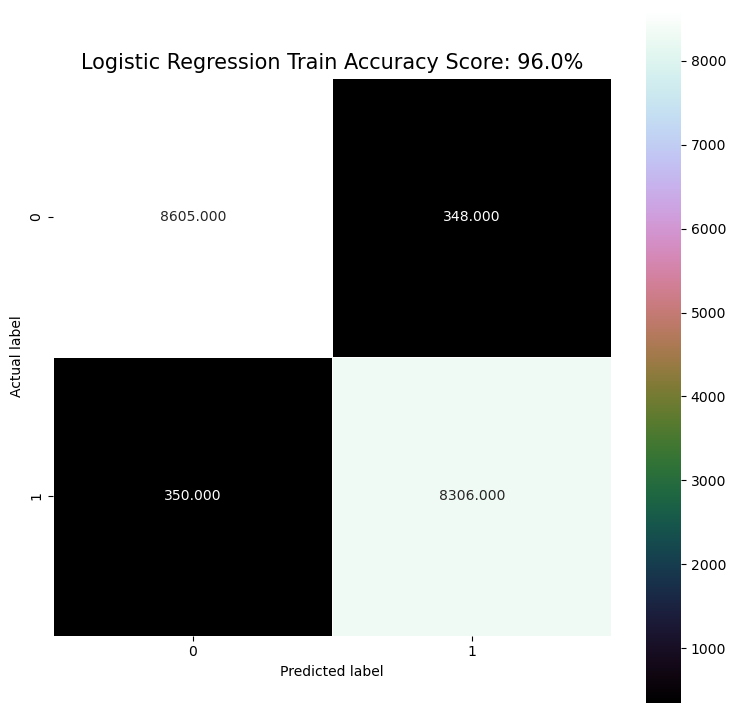

In [24]:
log_pred = logreg.predict(tfidf_train.toarray())
log_accuracy = accuracy_score(y_train,log_pred)
log_cm = metrics.confusion_matrix(y_train, log_pred)

accuracy_list = update_accuracy(log_cm, log_accuracy, "Logistic-Regression Train")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

plt.figure(figsize=(9,9))
sns.heatmap(log_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Logistic Regression Train Accuracy Score: {0:.1f}%'.format(log_accuracy*100)
plt.title(all_sample_title, size = 15)

In [25]:
y_test_pred = logreg.predict(tfidf_test)
print("Test Data Results")

print()

cmTest = confusion_matrix(y_test, y_test_pred)
tnTest = cmTest[0][0]
fpTest = cmTest[0][1] 
fnTest = cmTest[1][0] 
tpTest = cmTest[1][1] 


print("TPR:", (tpTest/(tpTest + fnTest)))
print("TNR:", (tnTest/(tnTest + fpTest)))
print()

print("FPR:", (fpTest/(tnTest + fpTest)))
print("FNR:", (fnTest/(tpTest + fnTest)))
print()
print("Accuracy  :", logreg.score(tfidf_test, y_test))

Test Data Results

TPR: 0.9333022388059702
TNR: 0.9247454625940682

FPR: 0.07525453740593183
FNR: 0.06669776119402986

Accuracy  : 0.9289121053826936


Text(0.5, 1.0, 'Logistic Regression Test Accuracy Score: 92.9%')

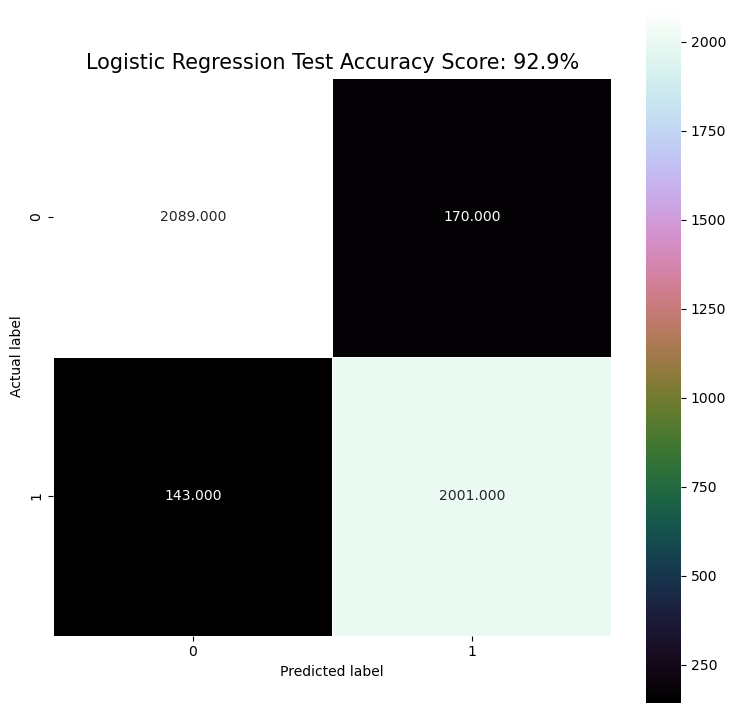

In [26]:
log_pred = logreg.predict(tfidf_test.toarray())
log_accuracy = accuracy_score(y_test,log_pred)
log_cm = metrics.confusion_matrix(y_test, log_pred)

accuracy_list = update_accuracy(log_cm, log_accuracy, "Logistic-Regression Test")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

plt.figure(figsize=(9,9))
sns.heatmap(log_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Logistic Regression Test Accuracy Score: {0:.1f}%'.format(log_accuracy*100)
plt.title(all_sample_title, size = 15)



Logistic Regression performed quite well of **96.1%** for training accuracy and **92.9%** for testing accuracy. The **gap difference of accuracy is quite minimal** which makes this a good model.

## Model 2 : Decision Tree

In [27]:
y = pd.DataFrame(news_final['label_translated']) #Response
x = pd.DataFrame(news_final.drop('label_translated', axis = 1)) #Predictors

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)

print(f"Train: {x_train.shape[0]} & {y_train.shape[0]}")
print(f"Test: {x_test.shape[0]} & {y_test.shape[0]}")



Train: 17609 & 17609
Test: 4403 & 4403


In [28]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 4)
clf.fit(x_train, y_train)

y_train_pred = clf.predict(x_train)
print("Train Data Results")
print()

cmTrain = confusion_matrix(y_train, y_train_pred)
tnTrain = cmTrain[0][0] 
fpTrain = cmTrain[0][1] 
fnTrain = cmTrain[1][0] 
tpTrain = cmTrain[1][1] 

print("TPR:", (tpTrain/(tpTrain + fnTrain)))
print("TNR:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR:", (fpTrain/(tnTrain + fpTrain)))
print("FNR:", (fnTrain/(tpTrain + fnTrain)))
print()
print("Accuracy:", clf.score(x_train, y_train))

Train Data Results

TPR: 0.6934021801491681
TNR: 0.7357769282662469

FPR: 0.2642230717337531
FNR: 0.3065978198508319

Accuracy: 0.7148049292975183


Text(0.5, 1.0, 'Decision Tree Train Accuracy Score: 71.5%')

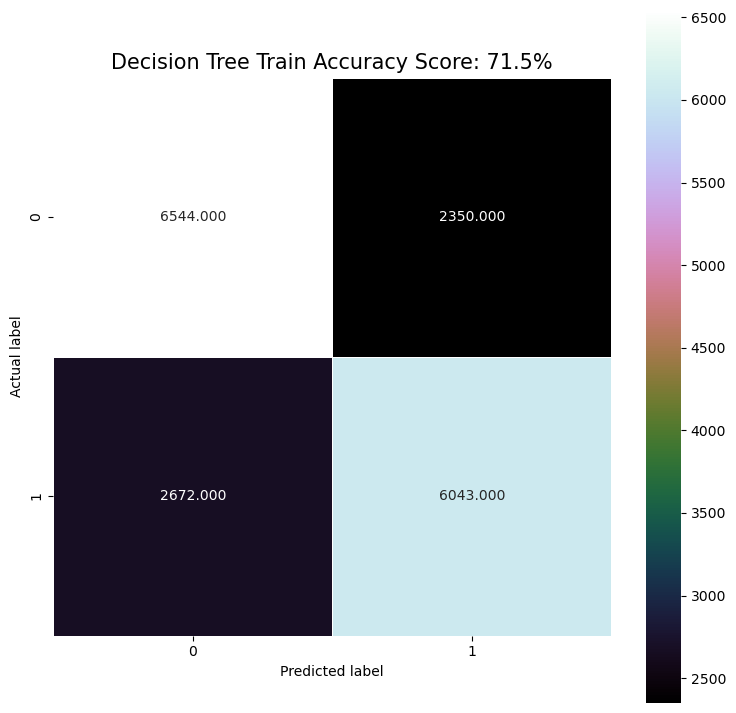

In [29]:
tree_pred = clf.predict(x_train)
tree_accuracy = accuracy_score(y_train,tree_pred)
tree_cm = metrics.confusion_matrix(y_train, tree_pred)

accuracy_list = update_accuracy(tree_cm, tree_accuracy, "Decision Tree Train")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

plt.figure(figsize=(9,9))
sns.heatmap(tree_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Decision Tree Train Accuracy Score: {0:.1f}%'.format(tree_accuracy*100)
plt.title(all_sample_title, size = 15)

In [30]:
y_test_pred = clf.predict(x_test)
print("Test Data Results")
print()

cmTest = confusion_matrix(y_test, y_test_pred)
tnTest = cmTest[0][0] 
fpTest = cmTest[0][1]
fnTest = cmTest[1][0]
tpTest = cmTest[1][1] 

print("TPR:", (tpTest/(tpTest + fnTest)))
print("TNR:", (tnTest/(tnTest + fpTest)))
print()

print("FPR:", (fpTest/(tnTest + fpTest)))
print("FNR:", (fnTest/(tpTest + fnTest)))
print()
print("Accuracy:", clf.score(x_test, y_test))

Test Data Results

TPR: 0.6772182254196643
TNR: 0.7415875754961173

FPR: 0.25841242450388263
FNR: 0.32278177458033575

Accuracy: 0.7111060640472405


Text(0.5, 1.0, 'Decision Tree Test Accuracy Score: 71.1%')

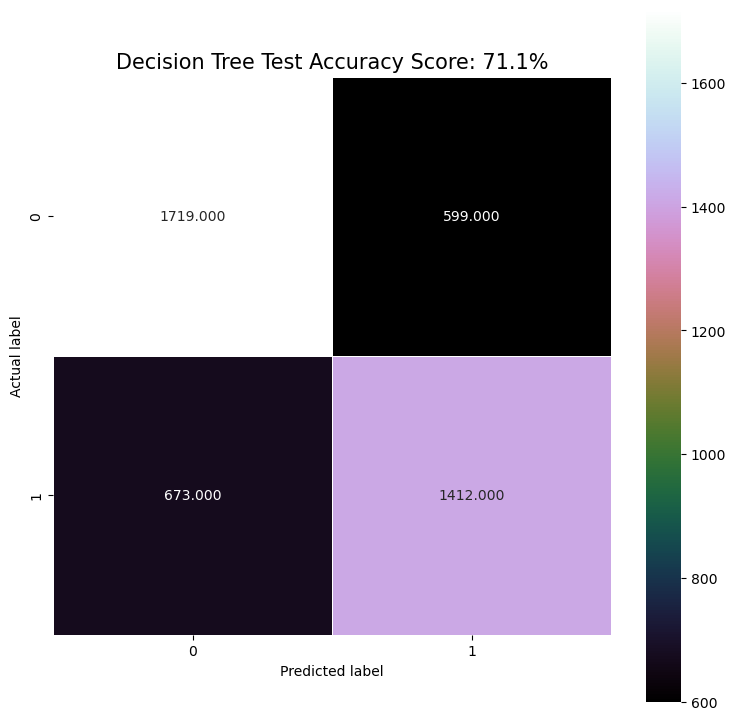

In [31]:
tree_pred = clf.predict(x_test)
tree_accuracy = accuracy_score(y_test,tree_pred)
tree_cm = metrics.confusion_matrix(y_test, tree_pred)

accuracy_list = update_accuracy(tree_cm, tree_accuracy, "Decision Tree Test")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

plt.figure(figsize=(9,9))
sns.heatmap(tree_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Decision Tree Test Accuracy Score: {0:.1f}%'.format(tree_accuracy*100)
plt.title(all_sample_title, size = 15)



Decision Tree has a **slightly lower accuracy** of both training and testing of around **71%**. The gap difference however is **less than 1%**, which is **ideal** when testing the model.

## Model 3 : Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(max_depth = 4, n_estimators = 100)       
rforest.fit(x_train, y_train.label_translated.ravel())

RandomForestClassifier(max_depth=4)

In [33]:
y_train_pred = rforest.predict(x_train)
print("Train Data Results")

print()

cmTrain = confusion_matrix(y_train, y_train_pred)
tnTrain = cmTrain[0][0]
fpTrain = cmTrain[0][1]
fnTrain = cmTrain[1][0] 
tpTrain = cmTrain[1][1]

print("TPR:", (tpTrain/(tpTrain + fnTrain)))
print("TNR:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR:", (fpTrain/(tnTrain + fpTrain)))
print("FNR:", (fnTrain/(tpTrain + fnTrain)))
print()
print("Accuracy:", rforest.score(x_train, y_train))

Train Data Results

TPR: 0.7666092943201377
TNR: 0.6999100517202609

FPR: 0.30008994827973917
FNR: 0.2333907056798623

Accuracy: 0.7329206655687432


Text(0.5, 1.0, 'Random Forest Train Accuracy Score: 73.3%')

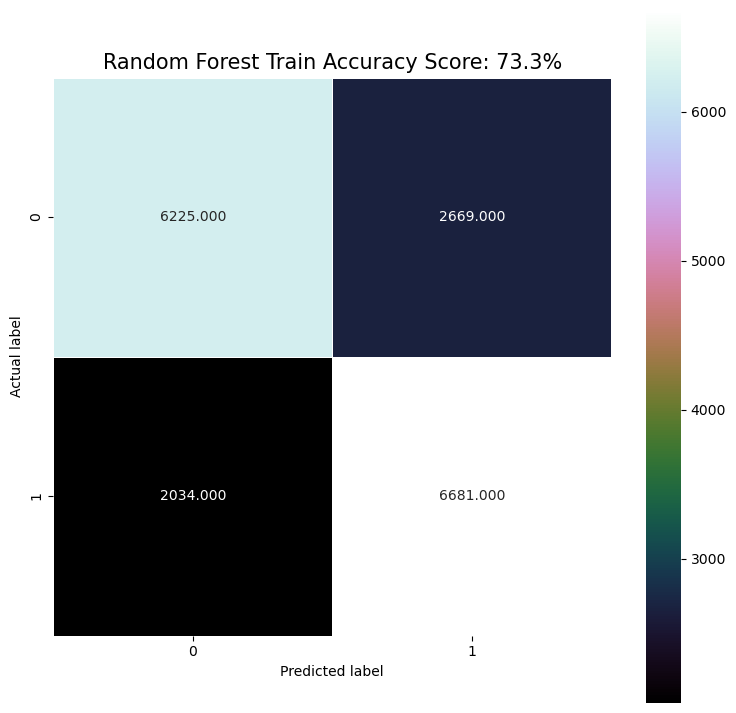

In [34]:
r_pred = rforest.predict(x_train)
r_accuracy = accuracy_score(y_train,r_pred)
r_cm = metrics.confusion_matrix(y_train, r_pred)

accuracy_list = update_accuracy(r_cm, r_accuracy, "Random Forest Train")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

plt.figure(figsize=(9,9))
sns.heatmap(r_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Random Forest Train Accuracy Score: {0:.1f}%'.format(r_accuracy*100)
plt.title(all_sample_title, size = 15)

In [35]:
y_test_pred = rforest.predict(x_test)
print("Test Data Results")
print()

cmTest = confusion_matrix(y_test, y_test_pred)
tnTest = cmTest[0][0] 
fpTest = cmTest[0][1] 
fnTest = cmTest[1][0] 
tpTest = cmTest[1][1] 

print("TPR:", (tpTest/(tpTest + fnTest)))
print("TNR:", (tnTest/(tnTest + fpTest)))
print()

print("FPR:", (fpTest/(tnTest + fpTest)))
print("FNR:", (fnTest/(tpTest + fnTest)))
print()
print("Accuracy:", rforest.score(x_test, y_test))

Test Data Results

TPR: 0.750599520383693
TNR: 0.6954270923209663

FPR: 0.30457290767903367
FNR: 0.24940047961630696

Accuracy: 0.7215534862593687


Text(0.5, 1.0, 'Random Forest Test Accuracy Score: 72.2%')

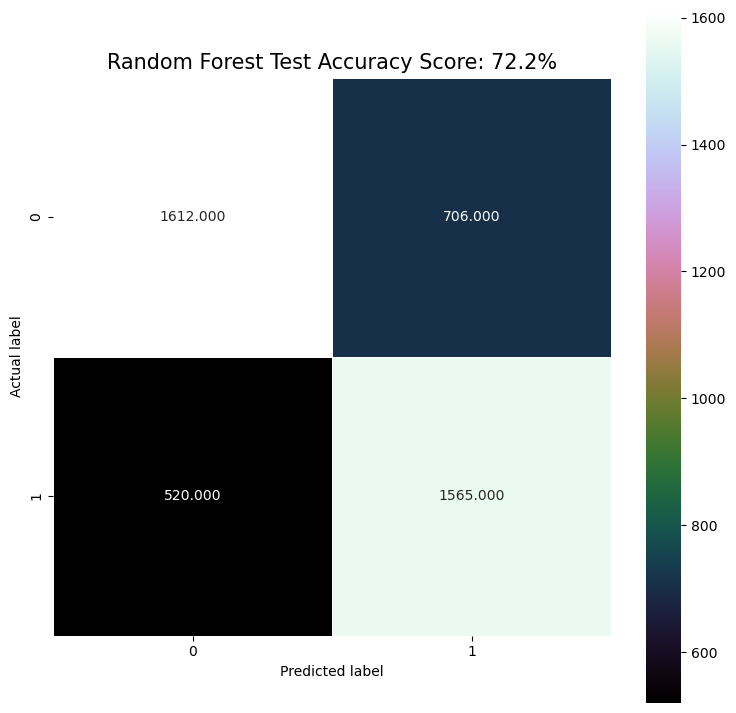

In [36]:
r_pred = rforest.predict(x_test)
r_accuracy = accuracy_score(y_test,r_pred)
r_cm = metrics.confusion_matrix(y_test, r_pred)

accuracy_list = update_accuracy(r_cm, r_accuracy, "Random Forest Test")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

plt.figure(figsize=(9,9))
sns.heatmap(r_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Random Forest Test Accuracy Score: {0:.1f}%'.format(r_accuracy*100)
plt.title(all_sample_title, size = 15)



Random Forest has a **slightly higher accuracy of 73%** than Decision Tree and a small difference in training and testing accuracy. Can this be improved by tuning the hyperparameters?

### Tuning hyperparameters using Cross-Validation

In [37]:
param_grid = {'max_depth': np.arange(2, 11),'n_estimators': np.arange(100,1001,100)}            
hyperGrid = GridSearchCV(RandomForestClassifier(),param_grid, scoring = 'accuracy', cv = 5)       
hyperGrid.fit(x_train, y_train.label_translated.ravel())

print(hyperGrid.best_estimator_)
print(np.abs(hyperGrid.best_score_))

RandomForestClassifier(max_depth=8, n_estimators=800)
0.7408141400642949


The best accuracy we can obtain from this model is **74% with max_depth of 9 and 700 estimators**.

## Model 4 : Support Vector Machine Classifier

In [38]:
from sklearn import svm
svmclf = svm.SVC(kernel='linear', C=1, probability=True)
svmclf.fit(tfidf_train, y_train.values.ravel()) 

y_train_pred = svmclf.predict(tfidf_train)
print("Train Data Results")
print()


cmTrain = confusion_matrix(y_train, y_train_pred)
tnTrain = cmTrain[0][0]
fpTrain = cmTrain[0][1] 
fnTrain = cmTrain[1][0] 
tpTrain = cmTrain[1][1] 

print("TPR:", (tpTrain/(tpTrain + fnTrain)))
print("TNR:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR:", (fpTrain/(tnTrain + fpTrain)))
print("FNR:", (fnTrain/(tpTrain + fnTrain)))
print()
print("Accuracy:", svmclf.score(tfidf_train, y_train))

Train Data Results

TPR: 0.8189328743545611
TNR: 0.8348324713289859

FPR: 0.16516752867101417
FNR: 0.1810671256454389

Accuracy: 0.826963484581748


Text(0.5, 1.0, 'SVM Train Accuracy Score: 82.7%')

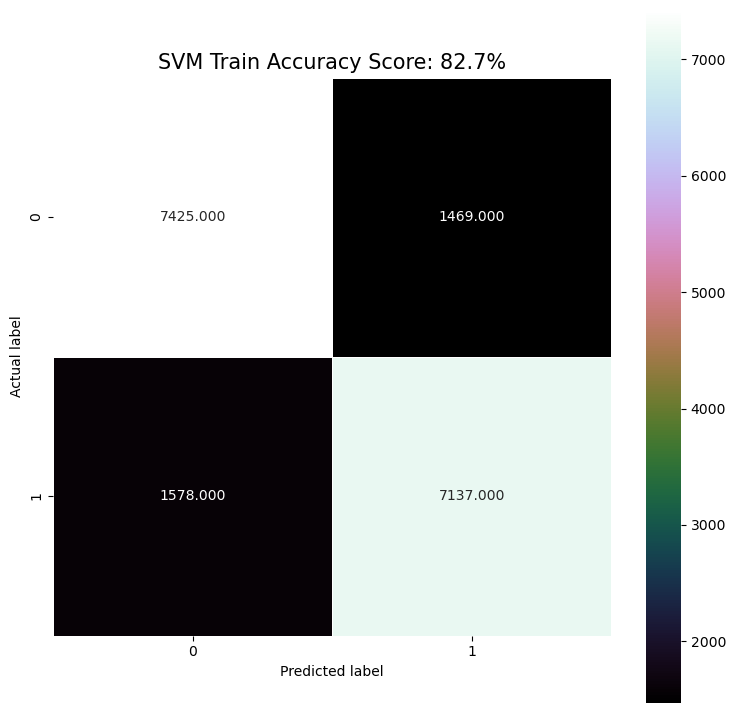

In [39]:
svm_pred = svmclf.predict(tfidf_train)
svm_accuracy = accuracy_score(y_train,svm_pred)
svm_cm = metrics.confusion_matrix(y_train, svm_pred)

accuracy_list = update_accuracy(svm_cm, svm_accuracy, "SVM Train")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

plt.figure(figsize=(9,9))
sns.heatmap(svm_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'SVM Train Accuracy Score: {0:.1f}%'.format(float(svm_accuracy*100))
plt.title(all_sample_title, size = 15)

In [40]:
y_test_pred = svmclf.predict(tfidf_test)
print("Test Data Results")
print()

cmTest = confusion_matrix(y_test, y_test_pred)
tnTest = cmTest[0][0] 
fpTest = cmTest[0][1] 
fnTest = cmTest[1][0] 
tpTest = cmTest[1][1] 

print("TPR:", (tpTest/(tpTest + fnTest)))
print("TNR:", (tnTest/(tnTest + fpTest)))
print()

print("FPR:", (fpTest/(tnTest + fpTest)))
print("FNR:", (fnTest/(tpTest + fnTest)))
print()
print("Accuracy:", svmclf.score(tfidf_test, y_test))

Test Data Results

TPR: 0.4935251798561151
TNR: 0.5133735979292493

FPR: 0.48662640207075064
FNR: 0.5064748201438849

Accuracy: 0.5039745627980922


Text(0.5, 1.0, 'SVM Test Accuracy Score: 50.4%')

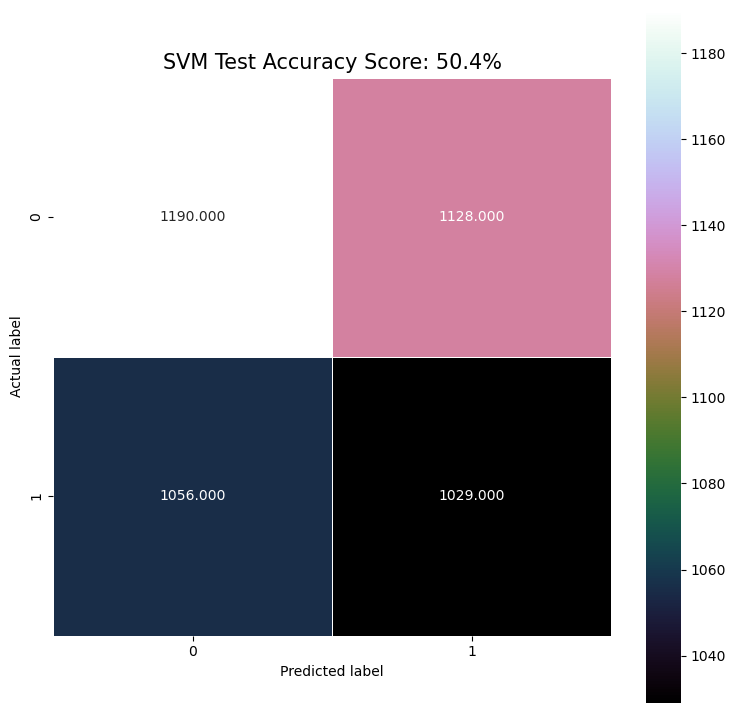

In [41]:
svm_pred = svmclf.predict(tfidf_test)
svm_accuracy = accuracy_score(y_test,svm_pred)
svm_cm = metrics.confusion_matrix(y_test, svm_pred)

accuracy_list = update_accuracy(svm_cm, svm_accuracy, "SVM Test")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

plt.figure(figsize=(9,9))
sns.heatmap(svm_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'SVM Test Accuracy Score: {0:.1f}%'.format(float(svm_accuracy*100))
plt.title(all_sample_title, size = 15)

While SVM has a high accuracy of **83.2%** for the training dataset, the test dataset however **plummets to 50%**. While the high accuracy is a good sign, the **big gap of accuracy** makes this model **not** an ideal one.<br>

What about *changing type of kernel* or *tuning hyperparameters*?

### Changing kernel to non-linear kernels

In [42]:
svmclf = svm.SVC(kernel='rbf', C=1, probability=True)
svmclf.fit(tfidf_train, y_train.values.ravel()) 

y_train_pred = svmclf.predict(tfidf_train)
print("Train Data Results")
print()

cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] 
fpTrain = cmTrain[0][1]
tnTrain = cmTrain[0][0] 
fnTrain = cmTrain[1][0] 

print("TPR:", (tpTrain/(tpTrain + fnTrain)))
print("TNR:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR:", (fpTrain/(tnTrain + fpTrain)))
print("FNR:", (fnTrain/(tpTrain + fnTrain)))
print()
print("Accuracy:", svmclf.score(tfidf_train, y_train))

Train Data Results

TPR: 0.9648881239242685
TNR: 0.9772880593658646

FPR: 0.022711940634135373
FNR: 0.0351118760757315

Accuracy: 0.9711511159066386


In [43]:
y_test_pred = svmclf.predict(tfidf_test)
print("Test Data Results")
print()

cmTest = confusion_matrix(y_test, y_test_pred)
tnTest = cmTest[0][0] 
fpTest = cmTest[0][1] 
fnTest = cmTest[1][0] 
tpTest = cmTest[1][1] 

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(tnTest + fpTest)))
print("FNR Test :\t", (fnTest/(tpTest + fnTest)))
print()
print("Accuracy:", svmclf.score(tfidf_test, y_test))

Test Data Results

TPR Test :	 0.47386091127098323
TNR Test :	 0.5327868852459017

FPR Test :	 0.4672131147540984
FNR Test :	 0.5261390887290168

Accuracy: 0.504883034294799


Changing to Radial basis function (RBF) kernel did not solve the gap issue.

In [44]:
svmclf = svm.SVC(kernel='poly', C=1, probability=True)
svmclf.fit(tfidf_train, y_train.values.ravel()) 

y_train_pred = svmclf.predict(tfidf_train)
print("Train Data Results")
print()

cmTrain = confusion_matrix(y_train, y_train_pred)
tnTrain = cmTrain[0][0] 
fpTrain = cmTrain[0][1] 
fnTrain = cmTrain[1][0] 
tpTrain = cmTrain[1][1] 

print("TPR:", (tpTrain/(tpTrain + fnTrain)))
print("TNR:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR:", (fpTrain/(tnTrain + fpTrain)))
print("FNR:", (fnTrain/(tpTrain + fnTrain)))
print()
print("Accuracy:", svmclf.score(tfidf_train, y_train))

Train Data Results

TPR: 0.9754446356855996
TNR: 0.9897683831796716

FPR: 0.010231616820328311
FNR: 0.02455536431440046

Accuracy: 0.9826793117156


In [45]:
y_test_pred = svmclf.predict(tfidf_test)
print("Test Data Results")
print()

cmTest = confusion_matrix(y_test, y_test_pred)
tnTest = cmTest[0][0] 
fpTest = cmTest[0][1] 
fnTest = cmTest[1][0] 
tpTest = cmTest[1][1] 

print("TPR:", (tpTest/(tpTest + fnTest)))
print("TNR:", (tnTest/(tnTest + fpTest)))
print()

print("FPR:", (fpTest/(tnTest + fpTest)))
print("FNR:", (fnTest/(tpTest + fnTest)))
print()
print("Accuracy:", svmclf.score(tfidf_test, y_test))

Test Data Results

TPR: 0.37985611510791367
TNR: 0.6246764452113891

FPR: 0.37532355478861085
FNR: 0.6201438848920864

Accuracy: 0.5087440381558028


Changing to Polynomial kernel did not solve the gap issue.

### Tuning the hyperparameters (gamma, coef0)

In [46]:
svmclf = svm.SVC(kernel='sigmoid', gamma=0.1, coef0=0.1, probability=True)
svmclf.fit(tfidf_train, y_train.values.ravel()) 

y_train_pred = svmclf.predict(tfidf_train)
print("Train Data Results")
print()


cmTrain = confusion_matrix(y_train, y_train_pred)
tnTrain = cmTrain[0][0] 
fpTrain = cmTrain[0][1] 
fnTrain = cmTrain[1][0] 
tpTrain = cmTrain[1][1] 

print("TPR:", (tpTrain/(tpTrain + fnTrain)))
print("TNR:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR:", (fpTrain/(tnTrain + fpTrain)))
print("FNR:", (fnTrain/(tpTrain + fnTrain)))
print()
print("Accuracy:", svmclf.score(tfidf_train, y_train))

Train Data Results

TPR: 0.0011474469305794606
TNR: 0.999887564650326

FPR: 0.00011243534967393749
FNR: 0.9988525530694206

Accuracy: 0.5055937304787325


In [47]:
y_test_pred = svmclf.predict(tfidf_test)
print("Test Data Results")
print()

cmTest = confusion_matrix(y_test, y_test_pred)
tnTest = cmTest[0][0] 
fpTest = cmTest[0][1] 
fnTest = cmTest[1][0] 
tpTest = cmTest[1][1]

print("TPR:", (tpTest/(tpTest + fnTest)))
print("TNR:", (tnTest/(tnTest + fpTest)))
print()

print("FPR:", (fpTest/(tnTest + fpTest)))
print("FNR:", (fnTest/(tpTest + fnTest)))
print()
print("Accuracy:", svmclf.score(tfidf_test, y_test))

Test Data Results

TPR: 0.0014388489208633094
TNR: 0.9987057808455565

FPR: 0.0012942191544434857
FNR: 0.9985611510791367

Accuracy: 0.5264592323415853


Tuning the hyperparameters of gamma, coef0, C and changing to sigmoid kernel **solved** the gap issue, but the accuracy is **too low**.

## Model 5 : Ensemble

In [48]:
from sklearn.ensemble import VotingClassifier
estimators=[('logreg',logreg), ('clf', clf), ('rforest', rforest), ('svmclf', svmclf)]
ensemble = VotingClassifier(estimators, voting='soft')

Text(0.5, 1.0, 'Ensemble Accuracy Score: 69.8%')

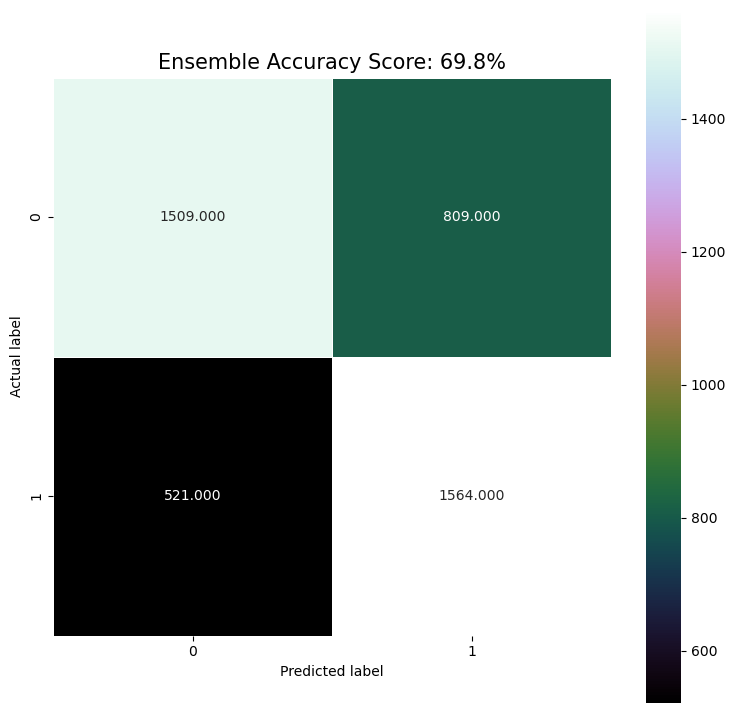

In [49]:
ensemble.fit(x_train, y_train.values.ravel())
ensemble.score(x_test, y_test)

ensemble_pred = ensemble.predict(x_test)
ensemble_accuracy = accuracy_score(y_test,ensemble_pred)
ensemble_cm = metrics.confusion_matrix(y_test, ensemble_pred)

accuracy_list = update_accuracy(ensemble_cm, ensemble_accuracy, "Ensemble")
accuracy_df.loc[len(accuracy_df)] = accuracy_list

plt.figure(figsize=(9,9))
sns.heatmap(ensemble_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'cubehelix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Ensemble Accuracy Score: {0:.1f}%'.format(ensemble_accuracy*100)
plt.title(all_sample_title, size = 15)



While ensemble models commonly helps to improve accuracy by combining multiple models, the model did not work for our dataset with only an accuracy of **71%**.


In [50]:
accuracy_df

,Model,Accuracy,True Pos,False Pos,True Neg,False Neg
0,Logistic-Regression Train,96.0,96.0,4.0,96.1,3.9
1,Logistic-Regression Test,92.9,92.2,7.8,93.6,6.4
2,Decision Tree Train,71.5,72.0,28.0,71.0,29.0
3,Decision Tree Test,71.1,70.2,29.8,71.9,28.1
4,Random Forest Train,73.3,71.5,28.5,75.4,24.6
5,Random Forest Test,72.2,68.9,31.1,75.6,24.4
6,SVM Train,82.7,82.9,17.1,82.5,17.5
7,SVM Test,50.4,47.7,52.3,53.0,47.0
8,Ensemble,69.8,65.9,34.1,74.3,25.7


Our task requires high accuracy on unseen data. Hence:

**Logistic Regression** performed the best and is the ideal model for our dataset. <br>
**Support Vector Machine Classifier** performed the worst as the big accuracy difference between training and testing indicates poor generalization ability.